In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch8/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [6]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [7]:
conv = nn.Conv2d(3, 16, kernel_size=3) # <1>
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [8]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [9]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

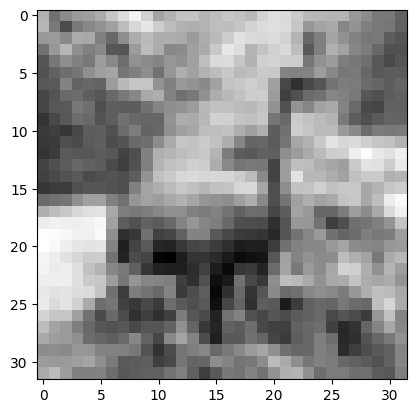

In [10]:
plt.imshow(img.mean(0), cmap='gray')
plt.show()

In [11]:
output.shape

torch.Size([1, 16, 30, 30])

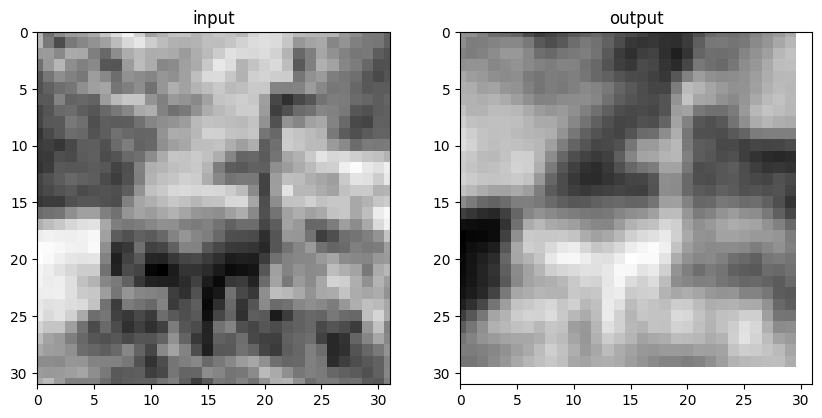

In [12]:
# bookskip
def plot_images(input, output, img_name=""):
    # Create a figure with two subplots
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.8))

    # Left subplot (input)
    ax1.imshow(input.mean(0), cmap='gray')
    ax1.set_title('input')
    ax1.set_xlim([0, 31])  # Set x-axis limits
    ax1.set_ylim([31, 0])  # Invert the y-axis

    # Right subplot (output)
    ax2.imshow(output[0, 0].detach(), cmap='gray')
    ax2.set_title('output')
    ax2.set_xlim([0, 31])  # Set x-axis limits
    ax2.set_ylim([31, 0])  # Invert the y-axis

    if img_name:
        plt.savefig(img_name)  # bookskip
    plt.show()

plot_images(img, output, 'Ch8_F2_PyTorch.png')

In [13]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) # <1>
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [14]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

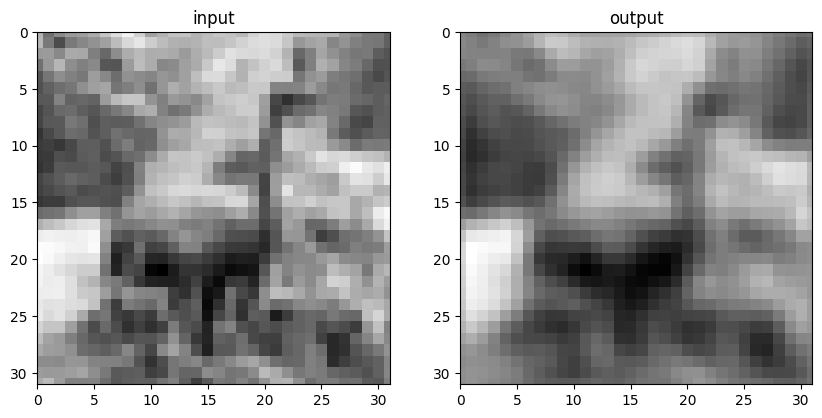

In [15]:
output = conv(img.unsqueeze(0))
plot_images(img, output, 'Ch8_F4_PyTorch.png')

In [16]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

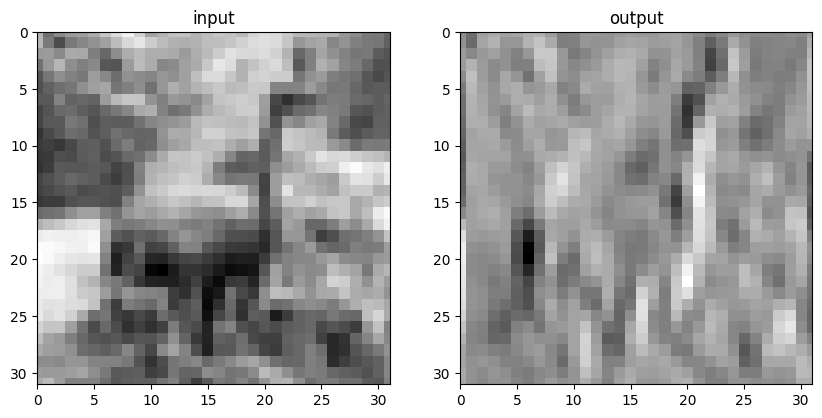

In [17]:
output = conv(img.unsqueeze(0))
plot_images(img, output, 'Ch8_F5_PyTorch.png')

In [18]:
conv_edge = nn.Conv2d(3, 1, kernel_size=3, padding=1)
conv_horizontal = nn.Conv2d(3, 1, kernel_size=3, padding=1)
conv_vertical = nn.Conv2d(3, 1, kernel_size=3, padding=1)
conv_blur = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv_edge.weight[:] = torch.tensor([[-1.0, -1.0, -1.0],
                                        [-1.0, 8.0, -1.0],
                                        [-1.0, -1.0, -1.0]])
    conv_edge.bias.zero_()
    conv_horizontal.weight[:] = torch.tensor([[1.0, 1.0, 1.0],
                                              [0.0, 0.0, 0.0],
                                              [-1.0, -1.0, -1.0]])
    conv_horizontal.bias.zero_()
    conv_vertical.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                            [-1.0, 0.0, 1.0],
                                            [-1.0, 0.0, 1.0]])
    conv_vertical.bias.zero_()
    conv_blur.weight[:] = torch.tensor([[1.0, 2.0, 1.0],
                                        [2.0, 4.0, 2.0],
                                        [1.0, 2.0, 1.0]]) / 16.0
    conv_blur.bias.zero_()

In [19]:
def plot_images(input, outputs, titles, img_name=""):
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(1, len(outputs) + 1, figsize=(10, 4.8))
    # First subplot (input)
    axs[0].imshow(input.mean(0), cmap='gray')
    axs[0].set_title('input')
    axs[0].set_xlim([0, 31])  # Set x-axis limits
    axs[0].set_ylim([31, 0])  # Invert the y-axis
    # Other subplots (outputs)
    for i, (output, title) in enumerate(zip(outputs, titles), start=1):
        axs[i].imshow(output[0, 0].detach(), cmap='gray')
        axs[i].set_title(title)
        axs[i].set_xlim([0, 31])  # Set x-axis limits
        axs[i].set_ylim([31, 0])  # Invert the y-axis
    if img_name:
        plt.savefig(img_name)  # bookskip
    plt.tight_layout()
    plt.show()

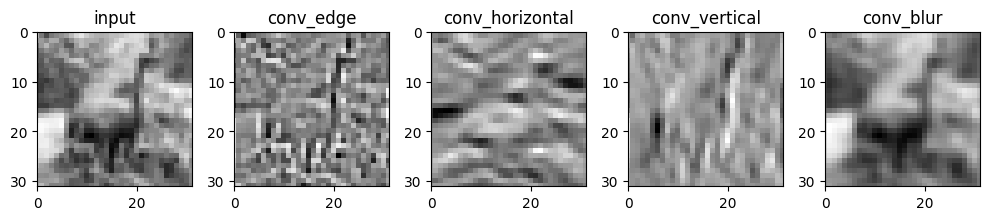

In [20]:
output1 = conv_edge(img.unsqueeze(0))
output2 = conv_horizontal(img.unsqueeze(0))
output3 = conv_vertical(img.unsqueeze(0))
output4 = conv_blur(img.unsqueeze(0))
plot_images(img, [output1, output2, output3, output4], ['conv_edge', 'conv_horizontal', 'conv_vertical', 'conv_blur'], 'Ch8_F2_PyTorch.png')

In [21]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [22]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ...
            )

In [23]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... <1>
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [24]:
for name, param in model.named_parameters():
    print(f"Layer: {name}, Parameters: {param.numel()}")

Layer: 0.weight, Parameters: 432
Layer: 0.bias, Parameters: 16
Layer: 3.weight, Parameters: 1152
Layer: 3.bias, Parameters: 8
Layer: 6.weight, Parameters: 16384
Layer: 6.bias, Parameters: 32
Layer: 8.weight, Parameters: 64
Layer: 8.bias, Parameters: 2


In [25]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [26]:
model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

In [27]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # <1>
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [28]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [29]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = F.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [30]:
model = Net()
model(img.unsqueeze(0))

tensor([[ 0.0190, -0.0683]], grad_fn=<AddmmBackward0>)

In [31]:
import datetime  # <1>

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <2>
        start_time = datetime.datetime.now()
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>
            
            outputs = model(imgs)  # <4>
            
            loss = loss_fn(outputs, labels)  # <5>

            optimizer.zero_grad()  # <6>
            
            loss.backward()  # <7>
            
            optimizer.step()  # <8>

            loss_train += loss.item()  # <9>

        end_time = datetime.datetime.now()
        epoch_duration = (end_time - start_time).total_seconds()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {:.6f}, Time {:.2f}s'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader), epoch_duration))  # <10>

In [32]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # <1>

model = Net()  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(  # <5>
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2025-06-08 14:34:27.755713 Epoch 1, Training loss 0.553273, Time 1.72s
2025-06-08 14:34:39.389411 Epoch 10, Training loss 0.332629, Time 1.30s
2025-06-08 14:34:52.348689 Epoch 20, Training loss 0.283454, Time 1.34s
2025-06-08 14:35:05.399002 Epoch 30, Training loss 0.259716, Time 1.28s
2025-06-08 14:35:18.432120 Epoch 40, Training loss 0.239583, Time 1.26s
2025-06-08 14:35:31.409170 Epoch 50, Training loss 0.220342, Time 1.46s
2025-06-08 14:35:44.441435 Epoch 60, Training loss 0.204420, Time 1.24s
2025-06-08 14:35:57.261905 Epoch 70, Training loss 0.190523, Time 1.29s
2025-06-08 14:36:10.689505 Epoch 80, Training loss 0.175177, Time 1.32s
2025-06-08 14:36:23.668655 Epoch 90, Training loss 0.160240, Time 1.40s
2025-06-08 14:36:36.904013 Epoch 100, Training loss 0.147124, Time 1.20s


In [33]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.95
Accuracy val: 0.90


In [34]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [35]:
loaded_model = Net()  # <1>
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

In [36]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [37]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        start_time = datetime.datetime.now()
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device) # <1>
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        end_time = datetime.datetime.now()
        epoch_duration = (end_time - start_time).total_seconds()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {:.6f}, Time {:.2f}s'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader), epoch_duration)) 

In [38]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2025-06-08 14:36:43.831980 Epoch 1, Training loss 0.591598, Time 6.02s
2025-06-08 14:36:47.707613 Epoch 10, Training loss 0.328330, Time 0.40s
2025-06-08 14:36:52.163547 Epoch 20, Training loss 0.289371, Time 0.36s
2025-06-08 14:36:56.326006 Epoch 30, Training loss 0.262738, Time 0.44s
2025-06-08 14:37:00.233507 Epoch 40, Training loss 0.241435, Time 0.50s
2025-06-08 14:37:05.260639 Epoch 50, Training loss 0.227982, Time 0.53s
2025-06-08 14:37:09.706318 Epoch 60, Training loss 0.211528, Time 0.44s
2025-06-08 14:37:14.019777 Epoch 70, Training loss 0.198672, Time 0.51s
2025-06-08 14:37:17.456679 Epoch 80, Training loss 0.186976, Time 0.32s
2025-06-08 14:37:20.734218 Epoch 90, Training loss 0.175323, Time 0.32s
2025-06-08 14:37:24.933440 Epoch 100, Training loss 0.162720, Time 0.42s


In [39]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.89


In [40]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device))

<All keys matched successfully>

In [41]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [42]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

2025-06-08 14:37:25.667682 Epoch 1, Training loss 0.535780, Time 0.48s
2025-06-08 14:37:30.628065 Epoch 10, Training loss 0.318478, Time 0.53s
2025-06-08 14:37:35.421189 Epoch 20, Training loss 0.277844, Time 0.42s
2025-06-08 14:37:39.742465 Epoch 30, Training loss 0.247302, Time 0.38s
2025-06-08 14:37:44.753708 Epoch 40, Training loss 0.222645, Time 0.48s
2025-06-08 14:37:49.012141 Epoch 50, Training loss 0.198655, Time 0.41s
2025-06-08 14:37:53.317497 Epoch 60, Training loss 0.175581, Time 0.44s
2025-06-08 14:37:57.573951 Epoch 70, Training loss 0.153517, Time 0.40s
2025-06-08 14:38:02.448086 Epoch 80, Training loss 0.132226, Time 0.51s
2025-06-08 14:38:07.749162 Epoch 90, Training loss 0.111634, Time 0.58s
2025-06-08 14:38:12.942799 Epoch 100, Training loss 0.092601, Time 0.42s
Accuracy train: 0.96
Accuracy val: 0.90


{'train': 0.9618, 'val': 0.897}

In [43]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


In [44]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

2025-06-08 14:38:15.985177 Epoch 1, Training loss 0.538893, Time 0.64s
2025-06-08 14:38:21.419034 Epoch 10, Training loss 0.316749, Time 0.63s
2025-06-08 14:38:25.812823 Epoch 20, Training loss 0.278414, Time 0.39s
2025-06-08 14:38:30.863302 Epoch 30, Training loss 0.246058, Time 0.48s
2025-06-08 14:38:35.151263 Epoch 40, Training loss 0.216454, Time 0.43s
2025-06-08 14:38:39.927816 Epoch 50, Training loss 0.189853, Time 0.44s
2025-06-08 14:38:44.261990 Epoch 60, Training loss 0.166369, Time 0.48s
2025-06-08 14:38:49.138339 Epoch 70, Training loss 0.144589, Time 0.49s
2025-06-08 14:38:53.893260 Epoch 80, Training loss 0.123749, Time 0.54s
2025-06-08 14:38:58.884266 Epoch 90, Training loss 0.104192, Time 0.49s
2025-06-08 14:39:03.658072 Epoch 100, Training loss 0.086164, Time 0.42s
Accuracy train: 0.96
Accuracy val: 0.89


In [45]:
sum(p.numel() for p in model.parameters())

38386

In [46]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # <1>
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))


In [47]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

2025-06-08 14:39:04.428145 Epoch 1, Training loss 0.5895642621122348
2025-06-08 14:39:09.278597 Epoch 10, Training loss 0.3671280568952014
2025-06-08 14:39:15.269110 Epoch 20, Training loss 0.32768733638107395
2025-06-08 14:39:20.623439 Epoch 30, Training loss 0.3069290626011077
2025-06-08 14:39:25.765028 Epoch 40, Training loss 0.289266809726217
2025-06-08 14:39:30.828955 Epoch 50, Training loss 0.2729009167783579
2025-06-08 14:39:35.222785 Epoch 60, Training loss 0.2587168991186057
2025-06-08 14:39:39.887477 Epoch 70, Training loss 0.24562013642803118
2025-06-08 14:39:45.241343 Epoch 80, Training loss 0.23353090099278528
2025-06-08 14:39:50.821785 Epoch 90, Training loss 0.22258411737004663
2025-06-08 14:39:55.803787 Epoch 100, Training loss 0.21275612645468134
Accuracy train: 0.91
Accuracy val: 0.89


In [48]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [49]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2025-06-08 14:39:56.472058 Epoch 1, Training loss 0.567082, Time 0.49s
2025-06-08 14:40:01.693489 Epoch 10, Training loss 0.383106, Time 0.74s
2025-06-08 14:40:07.309741 Epoch 20, Training loss 0.348922, Time 0.53s
2025-06-08 14:40:12.044849 Epoch 30, Training loss 0.330519, Time 0.44s
2025-06-08 14:40:16.468262 Epoch 40, Training loss 0.315267, Time 0.44s
2025-06-08 14:40:21.123723 Epoch 50, Training loss 0.299163, Time 0.43s
2025-06-08 14:40:25.641001 Epoch 60, Training loss 0.286947, Time 0.43s
2025-06-08 14:40:30.681983 Epoch 70, Training loss 0.277602, Time 0.54s
2025-06-08 14:40:35.269948 Epoch 80, Training loss 0.261216, Time 0.47s
2025-06-08 14:40:39.827076 Epoch 90, Training loss 0.249663, Time 0.43s
2025-06-08 14:40:44.179087 Epoch 100, Training loss 0.242165, Time 0.42s
Accuracy train: 0.90
Accuracy val: 0.88


In [50]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [51]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

2025-06-08 14:40:45.267052 Epoch 1, Training loss 0.472026, Time 0.83s
2025-06-08 14:40:50.360541 Epoch 10, Training loss 0.265572, Time 0.57s
2025-06-08 14:40:55.889510 Epoch 20, Training loss 0.205446, Time 0.47s
2025-06-08 14:41:01.071664 Epoch 30, Training loss 0.156617, Time 0.47s
2025-06-08 14:41:06.031823 Epoch 40, Training loss 0.114478, Time 0.45s
2025-06-08 14:41:11.093283 Epoch 50, Training loss 0.078784, Time 0.49s
2025-06-08 14:41:15.811341 Epoch 60, Training loss 0.051380, Time 0.47s
2025-06-08 14:41:20.803724 Epoch 70, Training loss 0.032973, Time 0.48s
2025-06-08 14:41:25.723007 Epoch 80, Training loss 0.068422, Time 0.50s
2025-06-08 14:41:32.116026 Epoch 90, Training loss 0.014912, Time 0.71s
2025-06-08 14:41:37.642877 Epoch 100, Training loss 0.010202, Time 0.62s
Accuracy train: 0.99
Accuracy val: 0.87


In [52]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [53]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

2025-06-08 14:41:38.524750 Epoch 1, Training loss 0.688583, Time 0.60s
2025-06-08 14:41:43.409878 Epoch 10, Training loss 0.351068, Time 0.54s
2025-06-08 14:41:48.999836 Epoch 20, Training loss 0.306100, Time 0.48s
2025-06-08 14:41:53.956814 Epoch 30, Training loss 0.274140, Time 0.51s
2025-06-08 14:41:59.770525 Epoch 40, Training loss 0.240247, Time 0.55s
2025-06-08 14:42:04.742828 Epoch 50, Training loss 0.207892, Time 0.49s
2025-06-08 14:42:10.143163 Epoch 60, Training loss 0.178272, Time 0.57s
2025-06-08 14:42:14.731156 Epoch 70, Training loss 0.151316, Time 0.44s
2025-06-08 14:42:19.398699 Epoch 80, Training loss 0.125515, Time 0.46s
2025-06-08 14:42:24.455673 Epoch 90, Training loss 0.100841, Time 0.45s
2025-06-08 14:42:29.999974 Epoch 100, Training loss 0.082608, Time 0.58s
Accuracy train: 0.96
Accuracy val: 0.90


In [54]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [55]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res"] = validate(model, train_loader, val_loader)

2025-06-08 14:42:31.006642 Epoch 1, Training loss 0.579853, Time 0.68s
2025-06-08 14:42:35.834772 Epoch 10, Training loss 0.320240, Time 0.53s
2025-06-08 14:42:41.260701 Epoch 20, Training loss 0.278713, Time 0.44s
2025-06-08 14:42:46.244011 Epoch 30, Training loss 0.241947, Time 0.58s
2025-06-08 14:42:51.391410 Epoch 40, Training loss 0.206907, Time 0.49s
2025-06-08 14:42:56.164345 Epoch 50, Training loss 0.174284, Time 0.47s
2025-06-08 14:43:01.020146 Epoch 60, Training loss 0.144634, Time 0.47s
2025-06-08 14:43:06.141016 Epoch 70, Training loss 0.115221, Time 0.50s
2025-06-08 14:43:11.095036 Epoch 80, Training loss 0.098537, Time 0.47s
2025-06-08 14:43:15.723112 Epoch 90, Training loss 0.070301, Time 0.44s
2025-06-08 14:43:20.312913 Epoch 100, Training loss 0.048193, Time 0.49s
Accuracy train: 0.97
Accuracy val: 0.89


In [56]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [57]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=100):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out
    


In [58]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

2025-06-08 14:43:28.801627 Epoch 1, Training loss 2.264129, Time 8.21s
2025-06-08 14:44:37.672760 Epoch 10, Training loss 0.386805, Time 7.65s
2025-06-08 14:46:01.529078 Epoch 20, Training loss 0.307697, Time 8.18s
2025-06-08 14:47:31.581540 Epoch 30, Training loss 0.238368, Time 9.62s
2025-06-08 14:48:59.433854 Epoch 40, Training loss 0.190111, Time 8.72s
2025-06-08 14:50:33.695242 Epoch 50, Training loss 0.143888, Time 9.33s
2025-06-08 14:52:00.434559 Epoch 60, Training loss 0.137874, Time 8.67s
2025-06-08 14:53:30.251878 Epoch 70, Training loss 0.104275, Time 9.59s
2025-06-08 14:54:48.861049 Epoch 80, Training loss 0.078264, Time 7.27s
2025-06-08 14:56:04.223369 Epoch 90, Training loss 0.077471, Time 8.34s
2025-06-08 14:57:17.911466 Epoch 100, Training loss 0.077840, Time 7.09s
Accuracy train: 0.96
Accuracy val: 0.86


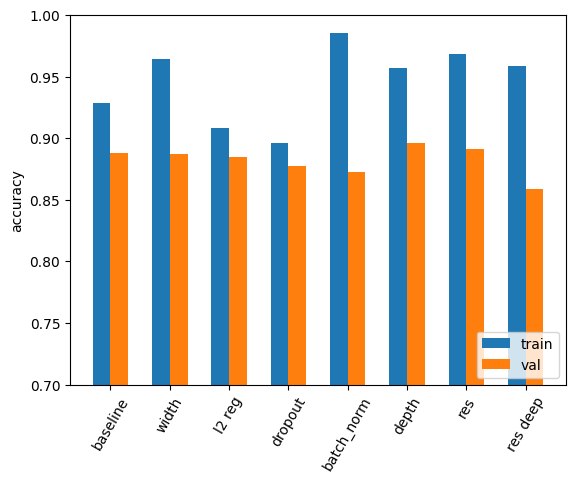

In [59]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()
